### **Fontes de pesquisa:**
> **GitHub** 
- Criando Previsões de Preços para 5 dias Adiante: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Criando%20Previso%CC%83es%20de%20Prec%CC%A7os%20para%205%20dias%20Adiante.ipynb
- Criando Previsões de Séries Temporais: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Princi%CC%81pios%20Ba%CC%81sicos%20para%20Prever%20Se%CC%81ries%20Temporais.ipynb

> **YouTube**
- Prevendo Dados com Janelas Deslizantes usando Python: https://www.youtube.com/watch?v=J_ak48BA4RM&t=204s
- Prevendo Vendas com ARIMA - Passo a Passo com Python: https://www.youtube.com/watch?v=v7rZpT8NCbk&t=351s
- Séries temporais com Python: https://www.youtube.com/watch?v=1m9u10eJ3Mk&t=1824s

> **Kaggle** 
- Time Series For beginners with ARIMA: https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima
- Bitcoin Price. Prediction by ARIMA: https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima
- ARIMA Model for Time Series Forecasting: https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting
- Everything you can do with a time series: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- AR, ARIMA, LSTM: https://www.kaggle.com/bogdanbaraban/ar-arima-lstm

> **Artigos** 
- Dicas para criar um modelo de previsão de séries temporais: https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
- Identificação de um modelo ARIMA(p,d,q): https://www.midomenech.com.br/identificacao-de-um-modelo-arimapdq/
- Take Time-Series a Level-Up with Walk-Forward Validation: https://sarit-maitra.medium.com/take-time-series-a-level-up-with-walk-forward-validation-217c33114f68
- Forecasting with ARIMA Using Python: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
- A Guide to Time Series Forecasting with ARIMA in Python 3: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-4-parameter-selection-for-the-arima-time-series-model
- ARIMA Model – Complete Guide to Time Series Forecasting in Python: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Métodos de previsão de séries temporais em python e R: https://datapeaker.com/big-data/lenguajes-de-ciencia-de-datos-en-2020/

In [ ]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() #media movel
    rolstd = timeseries.rolling(12).std() #desvio movel

    #Plot rolling statistics:
    fig = plt.subplots(figsize=(10,5))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, color='red', label='Médias Móveis')
    std = plt.plot(rolstd, color='black', label = 'Desvio Padrão')
    plt.legend(loc='best')
    plt.title('Teste de estacionariedade do preço semanal médio do PLD - Região Norte')
    plt.ylabel("Preço Médio (R$)")
    plt.xlabel("Periodo Observado")
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Resultados do teste de Dickey-Fuller')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)

def ehEstacionaria(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do teste','p-value','O critério de informação maximizado ','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    
    if(dfoutput['Estatística do teste'] < dfoutput['Valor crítico (5%)'] and dfoutput['p-value'] < 0.05):
        print('É estacionária.')
    else:
        print('Não é estacionária.')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df['inicio_semana'] = pd.to_datetime(df['inicio_semana'])

# Tranformando a coluna "Data" em index
df.set_index('inicio_semana', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


Text(0.5, 0, 'Periodo Observado')

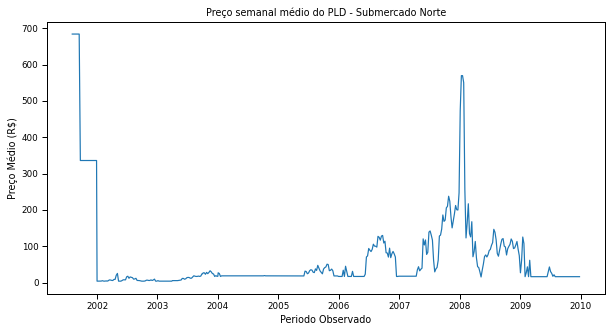

In [ ]:
fig = plt.subplots(figsize=(10,5))
plt.plot(df['preco_medio'])
plt.title("Preço semanal médio do PLD - Submercado Norte")
plt.ylabel("Preço Médio (R$)")
plt.xlabel("Periodo Observado")

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# resultado = seasonal_decompose(df.preco_medio)
# fig = plt.figure(figsize=(8, 6))  
# fig = resultado.plot()

### Análise de séries temporais

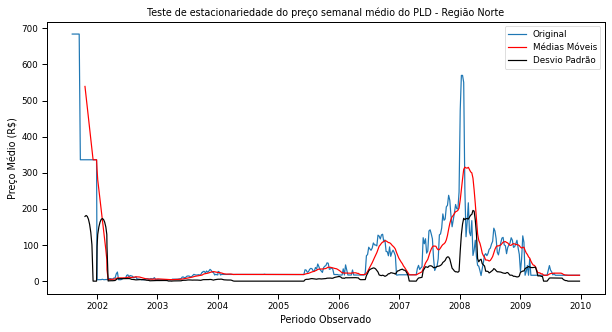

Resultados do teste de Dickey-Fuller
Estatística do teste                     -4.458580
p-value                                   0.000233
O critério de informação maximizado      16.000000
Número de observações usadas            426.000000
Valor crítico (1%)                       -3.445794
Valor crítico (5%)                       -2.868349
Valor crítico (10%)                      -2.570397
dtype: float64


In [ ]:
adf_test(df.preco_medio)

In [ ]:
ehEstacionaria(df.preco_medio)

É estacionária.


In [ ]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Velocidade do vento em Macau')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição da Velocidade')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Resultados do teste de Dickey-Fuller:
Teste Statistico           -4.4586
Valor-P                     0.0002
Lags Usados                16.0000
Números de Observações    426.0000
Valores Críticos (1%)      -3.4458
Valores Críticos (5%)      -2.8683
Valores Críticos (10%)     -2.5704
dtype: float64


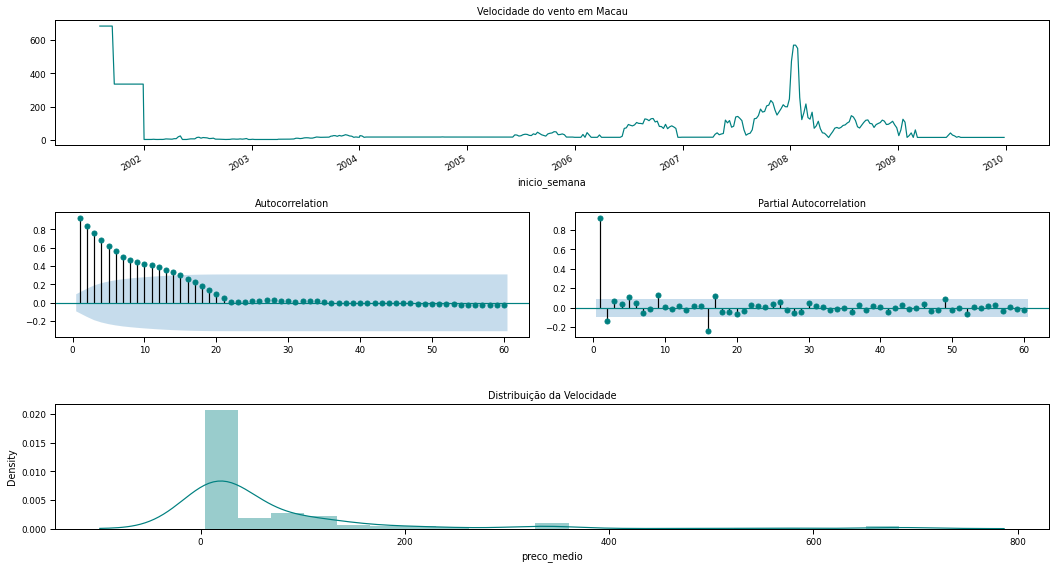

In [ ]:
checar_estacionariedade(df.preco_medio, lags_plots=60)

> Diferentes níveis de diferenciação

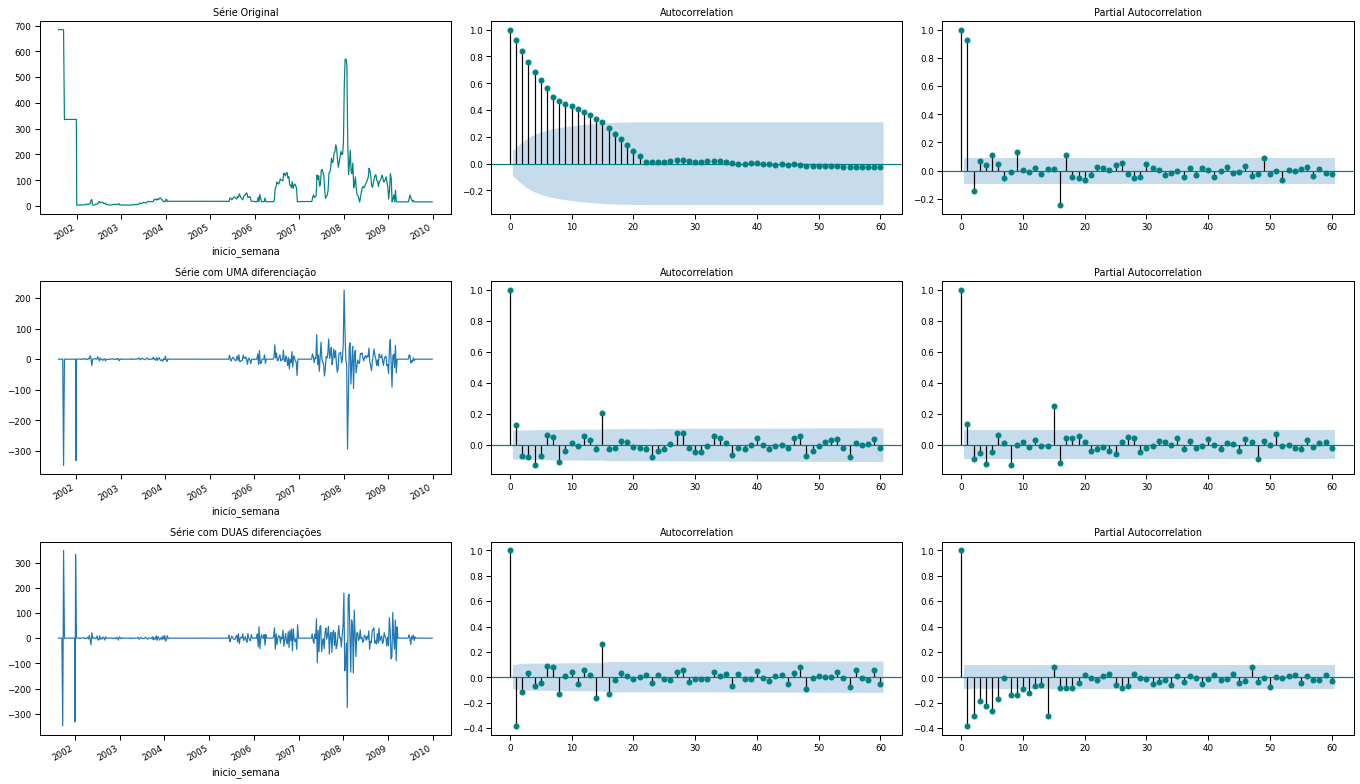

In [ ]:
fig = plt.figure(figsize=(19,11))
ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1))
ax3 = plt.subplot2grid((3, 3), (0, 2))
ax4 = plt.subplot2grid((3, 3), (1, 0))
ax5 = plt.subplot2grid((3, 3), (1, 1))
ax6 = plt.subplot2grid((3, 3), (1, 2))
ax7 = plt.subplot2grid((3, 3), (2, 0))
ax8 = plt.subplot2grid((3, 3), (2, 1))
ax9 = plt.subplot2grid((3, 3), (2, 2))

# Série Original
df.preco_medio.plot(ax=ax1, title='Série Original', color='teal')
plot_acf(df.preco_medio, lags=60, color='teal',ax=ax2)
plot_pacf(df.preco_medio, lags=60, method='ols', color='teal',ax=ax3);

# Série com UMA diferenciação
df.preco_medio.diff().dropna().plot(ax=ax4, title='Série com UMA diferenciação')
plot_acf(df.preco_medio.diff().dropna(), lags=60, color='teal',ax=ax5)
plot_pacf(df.preco_medio.diff().dropna(), lags=60, method='ols', color='teal',ax=ax6);

# Série com UMA diferenciação
df.preco_medio.diff().diff().dropna().plot(ax=ax7, title='Série com DUAS diferenciações')
plot_acf(df.preco_medio.diff().diff().dropna(), lags=60, color='teal',ax=ax8)
plot_pacf(df.preco_medio.diff().diff().dropna(), lags=60, method='ols', color='teal',ax=ax9);

plt.tight_layout()

### Separação treino e teste

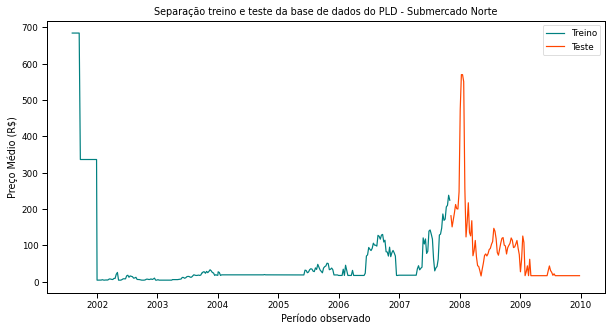

In [ ]:
size = int(len(df.preco_medio) *  0.75)
train = df.preco_medio[:size]
test = df.preco_medio[size:]

plt.figure(figsize=(10,5))
plt.title('Separação treino e teste da base de dados do PLD - Submercado Norte')
plt.plot(train, color='teal')
plt.plot(test, color='orangered')
plt.legend(['Treino','Teste'])
plt.xlabel('Período observado')
plt.ylabel('Preço Médio (R$)')
plt.show()

## Criando o modelo

### **Previsão - Dentro da Amostra**

In [ ]:
def predict_data(data, params):
    model = ARIMA(data, order=params)
    model_fit = model.fit(disp=0)
    if params[1] == 0:
        pred = model_fit.predict()
        orig = data
    else:
        pred = model_fit.predict(typ='levels')
        orig = data[params[1]:]
    return orig, pred, model_fit

In [ ]:
def plot_predict_data(orig, pred, start, end):
    plt.plot(orig[start:end],label='Original')
    plt.plot(pred[start:end],'--',label='Previsão')
    plt.title("Previsão dentro da amostra - PLD Norte")
    plt.legend()
    plt.show()
    print("MSE: " + str(mean_squared_error(pred.values, orig.values)))
    print("RMSE: " + str(np.sqrt(mean_squared_error(pred.values, orig.values))))
    print("MAE: " + str(mean_absolute_error(pred.values, orig.values)))
    print("MAPE: " + str(mean_absolute_percentage_error(pred.values, orig.values)))

> ORDER (7,2,8) => RECOMENDADO PELO **ALGORITMO**

In [ ]:
original,predict,model_fit = predict_data(df.preco_medio,(7,2,8))

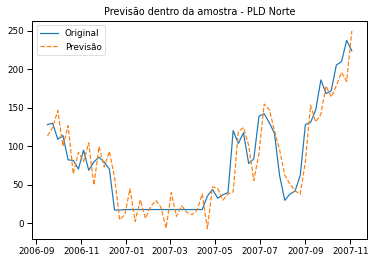

MSE: 1054.9865482021555
RMSE: 32.48055646386243
MAE: 15.877770478947605
MAPE: 3.807928287637415


In [ ]:
plot_predict_data(original,predict,270,330)

> ORDER (1,0,1) => RECOMENDADO PELO **AUTO-ARIMA**

In [ ]:
original_aa,predict_aa,model_fit_aa = predict_data(df.preco_medio,(1,0,1))

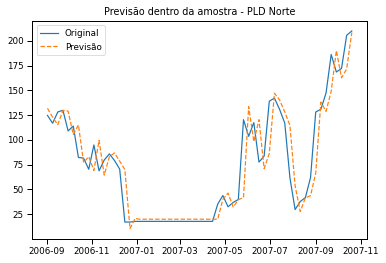

MSE: 1830.5231083983779
RMSE: 42.78461298642747
MAE: 12.954002753614807
MAPE: 0.2481778767649182


In [ ]:
plot_predict_data(original_aa,predict_aa,270,330)

> TESTANDO OUTROS MODELOS

In [ ]:
t_orig,t_pred,t_model = predict_data(df.preco_medio,(1,0,0))

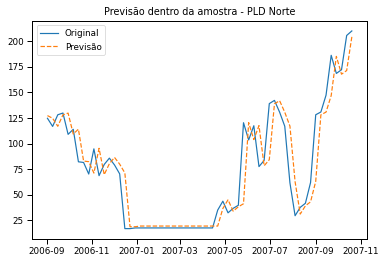

MSE: 1809.664943267524
RMSE: 42.540156831722236
MAE: 12.3783245254674
MAPE: 0.21161908708997546


In [ ]:
plot_predict_data(t_orig,t_pred,270,330)

> Previsão in-of-sample + 14 passos a frente **=> ORDER (7,2,8)**

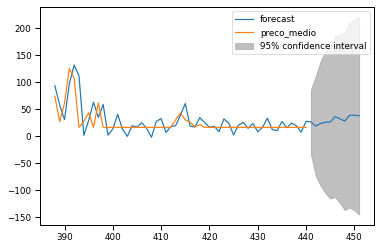

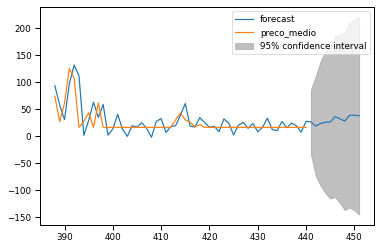

In [ ]:
model_fit.plot_predict(390,453,alpha=0.05)

### **Previsão - Fora da Amostra**

> Separação treino e teste

In [ ]:
def split_dataset(data, set_size, hide_series):
    x = data
    size = int(len(x) - set_size)
    train, test = x[0:size], x[size:len(x)]
    if hide_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [ ]:
train, test = split_dataset(df.preco_medio, 4, True)


BASE DE TREINO
 inicio_semana
2009-10-31    16.31
2009-11-07    16.31
2009-11-14    16.31
2009-11-21    16.31
2009-11-28    16.31
Name: preco_medio, dtype: float64

BASE DE TESTE
 inicio_semana
2009-12-05    16.31
2009-12-12    16.31
2009-12-19    16.31
2009-12-26    16.31
Name: preco_medio, dtype: float64


> Previsão de 1 passo a frente - **FORECAST**

In [ ]:
# Modelo (7,2,8) => Pesquisa em grade
model = ARIMA(train, order=(7,2,8))
arima_model = model.fit(disp=0)
arima_model.forecast()[0]

array([24.44738368])

In [ ]:
# Modelo (1,0,1) => Auto-Arima
model_aa = ARIMA(train, order=(1,0,1))
arima_model_aa = model_aa.fit(disp=0)
arima_model_aa.forecast()[0]

array([18.56185518])

> Previsão de VARIOS passo a frente - **FORECAST**

In [ ]:
train, test = split_dataset(df.preco_medio, 14, False)

BASE DE TREINO:  429
BASE DE TESTE:   14


In [ ]:
model = ARIMA(train, order=(7,2,8))
arima_model_nSteps = model.fit(disp=0)
forecast = arima_model_nSteps.forecast(14)[0]
forecast

array([25.78238488, 25.64336766, 32.61808887, 24.7334139 , 22.03052298,
       38.40865545, 37.16949184, 31.37033005, 39.26917577, 39.79697433,
       44.65329272, 51.7772678 , 46.17912852, 50.50202071])

In [ ]:
from pandas.core.frame import DataFrame
dataset = DataFrame(test)
dataset['previsao'] = forecast
dataset.dropna(inplace=True)
dataset.head()

,preco_medio,previsao
inicio_semana,,
2009-09-26,16.31,25.782385
2009-10-03,16.31,25.643368
2009-10-10,16.31,32.618089
2009-10-17,16.31,24.733414
2009-10-24,16.31,22.030523


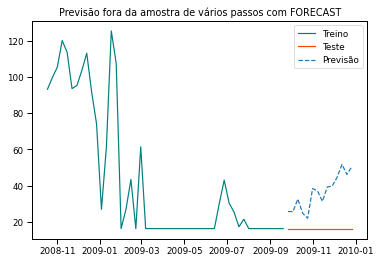

MSE: 492.7173249963127
RMSE: 22.197236877510512
MAE: 20.113865391476818
MAPE: 0.5190448450475922


In [ ]:
plt.plot(train[380:],color='teal',label='Treino')
plt.plot(dataset['preco_medio'],color='orangered',label='Teste')
plt.plot(dataset['previsao'],'--',label='Previsão')
plt.title("Previsão fora da amostra de vários passos com FORECAST")
plt.legend()
plt.show()
print("MSE: " + str(mean_squared_error(dataset['previsao'].values, dataset['preco_medio'].values)))
print("RMSE: " + str(np.sqrt(mean_squared_error(dataset['previsao'].values, dataset['preco_medio'].values))))
print("MAE: " + str(mean_absolute_error(dataset['previsao'].values, dataset['preco_medio'].values)))
print("MAPE: " + str(mean_absolute_percentage_error(dataset['previsao'].values, dataset['preco_medio'].values)))

> Previsão de VARIOS passos a frente - **ALGORITMO**

In [ ]:
from pandas.core.frame import DataFrame
import warnings
from math import sqrt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def prediction(dataset, params, steps):
    # split into train and test sets
    x = dataset
    size = int(len(x) - steps)
    train, test = x[0:size], x[size:len(x)]

    prediction = []
    confM=[]
    confm=[]
    history = [x for x in train]
    for t in test.values:
        model = ARIMA(history, order=params).fit(disp=0)
        y,err,ci = model.forecast(steps=len(test), alpha=0.05)
        confm.append(ci[0][0])
        confM.append(ci[0][1])
        prediction.append(y[0])
        history.append(t)
    test_ = DataFrame(test)
    test_['predictions_wf'] = prediction
    # test_ = DataFrame(test[0:len(test)-1])
    # test_['predictions_wf'] = prediction[1:]
    print(test_)
    return train, test_, confm, confM

In [ ]:
order = (7,2,8)
r_train, test_,ci_M,ci_m = prediction(train, order, 7)

               preco_medio  predictions_wf
inicio_semana                             
2009-10-17           16.31        7.772420
2009-10-24           16.31       16.696012
2009-10-31           16.31       34.205272
2009-11-07           16.31       11.952636
2009-11-14           16.31       10.150798
2009-11-21           16.31       27.609172
2009-11-28           16.31       15.452583


> Plotando os resultados

In [ ]:
def plot_prediction(train, test_, ci_m, ci_M,start):
    error = sqrt(mean_squared_error(test_.iloc[0:,[0]], test_.predictions_wf))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train[start:], label='Treino', color="teal")
    ax.plot(test_.iloc[0:,[0]], label='Teste',color="orangered")
    ax.plot(test_.predictions_wf, '--,m', label='Previsão')
    ax.fill_between(test_.predictions_wf.index,
                    ci_m,
                    ci_M, color='b', alpha=.15, label='conf. 95%')
    ax.set_title("Previsão do PLD - Submercado Norte")
    ax.set_xlabel('Data')
    ax.set_ylabel('Preço Médio (R$)')
    plt.suptitle(["RMSE:", round(error,3)])
    plt.legend()
    plt.show()
    print("MSE: " + str(mean_squared_error(test_['predictions_wf'], test_.iloc[0:,[0]])))
    print("RMSE: " + str(np.sqrt(mean_squared_error(test_['predictions_wf'], test_.iloc[0:,[0]]))))
    print("MAE: " + str(mean_absolute_error(test_['predictions_wf'], test_.iloc[0:,[0]])))
    print("MAPE: " + str(mean_absolute_percentage_error(test_['predictions_wf'], test_.iloc[0:,[0]])))

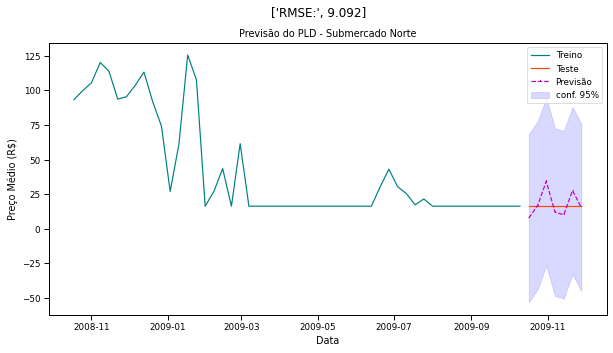

MSE: 82.65841189316053
RMSE: 9.091667167970929
MAE: 7.070288433980666
MAPE: 0.4401146346145663


In [ ]:
plot_prediction(r_train, test_, ci_m, ci_M, 380)

> Analisando as métricas de erro

In [ ]:
print("MSE: " + str(mean_squared_error(test_['predictions_wf'], test_.iloc[0:,[0]])))
print("RMSE: " + str(np.sqrt(mean_squared_error(test_['predictions_wf'], test_.iloc[0:,[0]]))))
print("MAE: " + str(mean_absolute_error(test_['predictions_wf'], test_.iloc[0:,[0]])))
print("MAPE: " + str(mean_absolute_percentage_error(test_['predictions_wf'], test_.iloc[0:,[0]])))

MSE: 82.65841189316053
RMSE: 9.091667167970929
MAE: 7.070288433980666
MAPE: 0.4401146346145663


### Testanto outros modelos
> ORDER(1,0,1)

In [ ]:
order = (1,0,1)
r_train, r_test,conf_m, conf_M = prediction(train,order,7)

               preco_medio  predictions_wf
inicio_semana                             
2009-10-17           16.31       18.604208
2009-10-24           16.31       18.600552
2009-10-31           16.31       18.590591
2009-11-07           16.31       18.585741
2009-11-14           16.31       18.579878
2009-11-21           16.31       18.572933
2009-11-28           16.31       18.567972


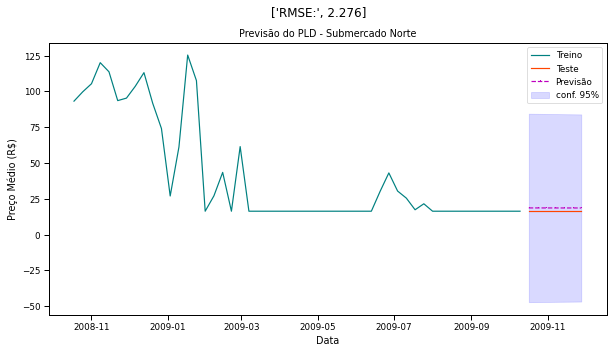

MSE: 5.180251134086055
RMSE: 2.27601650567083
MAE: 2.275982057214898
MAPE: 0.12245651839901628


In [ ]:
plot_prediction(r_train, r_test, conf_m, conf_M, 380)

> ORDER(1,0,0)

In [ ]:
order = (1,0,0)
r_train, r_test,conf_m, conf_M = prediction(train,order,7)

               preco_medio  predictions_wf
inicio_semana                             
2009-10-17           16.31       18.224151
2009-10-24           16.31       18.215946
2009-10-31           16.31       18.211007
2009-11-07           16.31       18.206354
2009-11-14           16.31       18.201317
2009-11-21           16.31       18.196745
2009-11-28           16.31       18.185529


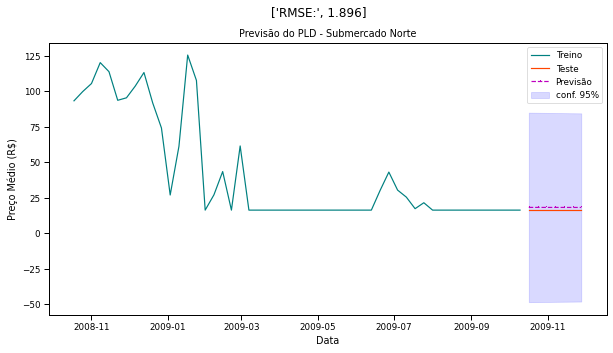

MSE: 3.5944409206187333
RMSE: 1.8959010840807948
MAE: 1.8958641588493859
MAPE: 0.1041344289896211


In [ ]:
plot_prediction(r_train, r_test, conf_m, conf_M, 380)

> ORDER(0,0,1)

In [ ]:
order = (0,0,1)
r_train, r_test,conf_m, conf_M = prediction(train,order,7)

               preco_medio  predictions_wf
inicio_semana                             
2009-10-17           16.31       41.982667
2009-10-24           16.31       45.690908
2009-10-31           16.31       42.254320
2009-11-07           16.31       45.206578
2009-11-14           16.31       42.446202
2009-11-21           16.31       44.794790
2009-11-28           16.31       42.575208


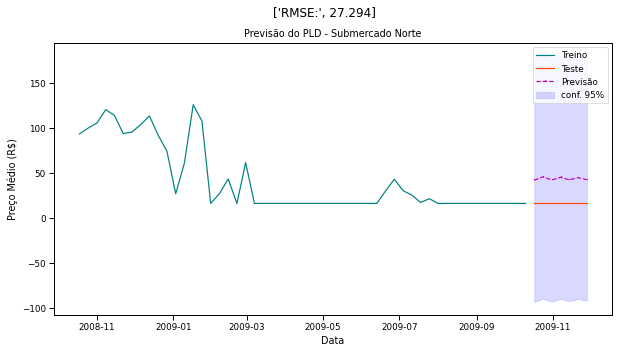

MSE: 744.9698642667682
RMSE: 27.294136078410105
MAE: 27.25438194875615
MAPE: 0.6251879380804828


In [ ]:
plot_prediction(r_train, r_test, conf_m, conf_M, 380)